# Effect of the planarity decriptor (MPP), Scaffold descriptors and other structural descriptors on Ered predictions

## Notebook will show that these descriptors doesn't significantly improve the Ered prediction accuracy  of the GPR model

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns

import rdkit.Chem as Chem
pd.set_option('display.max_columns', None)

In [95]:
ERed_data=pd.read_csv(r"./Data/BTZ_smi_Ered_MPP_2763.csv",usecols=["SMILES","Ered_ag","MPP(A)"])
ERed_data.head()

SMILES    MPP(A)  Ered_ag
0   Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C  0.908587    -2.58
1       CCN1CCN(CCOC)c2c1cc1nsnc1c2C  0.799408    -2.58
2   CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C  1.279319    -2.61
3    CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21  1.039480    -2.63
4  CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C  1.296932    -2.65

# Checking for duplicate smiles

In [96]:
def remove_duplicate_smi(df,smi_col="SMILES"):
    """ df: dataframe with the 'SMILES' column """
    temp=df.shape[0]
    print(f"Before: df.shape={df.shape}")
    df[smi_col]=df[smi_col].apply(lambda smi:Chem.MolToSmiles(Chem.MolFromSmiles(smi)))
    df=df.drop_duplicates(subset=smi_col)
    print(f"After: df.shape={df.shape}")
    print(f"Removed {df.shape[0]-temp} duplicate smiles")
    return df


In [97]:
ERed_data=remove_duplicate_smi(df=ERed_data,smi_col="SMILES")

Before: df.shape=(2763, 3)
After: df.shape=(2763, 3)
Removed 0 duplicate smiles


# No duplicate SMILES found

In [98]:
ERed_data.index=np.arange(len(ERed_data))
ERed_data.head()

SMILES    MPP(A)  Ered_ag
0   Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C  0.908587    -2.58
1       CCN1CCN(CCOC)c2c1cc1nsnc1c2C  0.799408    -2.58
2   CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C  1.279319    -2.61
3    CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21  1.039480    -2.63
4  CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C  1.296932    -2.65

# Feature Generation with the RDKIT

In [99]:
def All_Mordred_descriptors(data,ignore_3D=True):
    """
    Function will return all mordred features
    """
    from mordred import Calculator, descriptors
    from rdkit.Chem import AllChem
    calc = Calculator(descriptors, ignore_3D=ignore_3D)
    # mols = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in data]
    mols = []
    for smi in data:
        m=Chem.MolFromSmiles(smi)
        # m=Chem.AddHs(m) # for 3D descriptors
        # AllChem.EmbedMolecule(m) # for 3D descriptors
        # AllChem.UFFOptimizeMolecule(m)  # for 3D descriptors
        mols.append(m)
    # pandas df
    df = calc.pandas(mols)
    return df

In [100]:
# call function
df_mordred=All_Mordred_descriptors(ERed_data.SMILES)
df_rdkit=df_mordred.copy()

100%|██████████| 2763/2763 [01:07<00:00, 41.06it/s]


# Make a folder to save output files

In [101]:
import os
# Directory
directory = "planarity_hypo_test_2763btzs_onlymord"
  
# Parent Directory path
parent_dir = "./"
  
# Path
path = os.path.join(parent_dir, directory)
if not os.path.isdir(path):  
    os.mkdir(path)
    print("Directory '% s' created" % directory)

In [102]:
folder_path=directory+"/"

In [103]:
print(f"shape of the features set = {df_rdkit.shape}")

shape of the features set = (2763, 1613)


# Data cleaning

In [104]:
def data_cleaning(df):
    # check columns with nan
    columns_with_nan=df.columns[df.isna().any()]
    print(f"Removing {len(columns_with_nan)} columns with nan, if any")
    print(f"Before: df.shape={df.shape}")
    df = df.dropna(axis='columns')
    # df = df.drop(columns=columns_with_nan)
    print(f"After: df.shape={df.shape} \n")    
    

    # Remove duplicates
    print(f"removing {sum(df.columns.duplicated())} duplicate columns, if any")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,~df.columns.duplicated()].copy()
    print(f"After: df.shape={df.shape} \n")
    
    
    # Remove columns with a unique value
    print(f"removing {sum(df.nunique()<2)} columns values with a unique value")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,df.nunique()>1]
    print(f"After: df.shape={df.shape} \n")
    
    print("returning a clean df")
    return df


In [105]:
def remove_corr_features(Xdata,corr_cutoff = 0.75):
    """
    This function will drop highly correlated features
    Output: a pd.Dataframe 
    """
    cor_matrix=Xdata.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_cutoff)]
    print(f"Dropped %d features with correlation coeff. > %0.2f" %(len(to_drop),corr_cutoff))

    Xdata=Xdata.drop(columns=to_drop,axis=1)
    print(f"Remaining features %d" %(Xdata.shape[1]))
    return Xdata

In [106]:
df_rdkit=data_cleaning(df=df_rdkit)

Removing 0 columns with nan, if any
Before: df.shape=(2763, 1613)
After: df.shape=(2763, 1613) 

removing 0 duplicate columns, if any
Before: df.shape=(2763, 1613)
After: df.shape=(2763, 1613) 

removing 262 columns values with a unique value
Before: df.shape=(2763, 1613)
After: df.shape=(2763, 1351) 

returning a clean df


# Remove highly correlated features

In [107]:
df_rdkit_uncorr=remove_corr_features(Xdata=df_rdkit, corr_cutoff=0.8)
print(df_rdkit_uncorr.shape)

Dropped 896 features with correlation coeff. > 0.80
Remaining features 455
(2763, 455)


In [108]:
df_rdkit_uncorr.head()

ABC  nAcid   SpMAD_A       VR1_A  nBridgehead  nHetero  nN  nO  \
0  15.751268      0  1.281524  181.928976            0        6   5   0   
1  15.423098      0  1.316222  173.385876            0        6   4   1   
2  15.601438      0  1.284615  126.083770            0        6   5   0   
3  16.020815      0  1.304845  156.798836            0        6   5   0   
4  16.199155      0  1.292546  139.986453            0        6   5   0   

    AATS0dv   AATS5dv   AATS6dv   AATS7dv   AATS8dv    AATS3d    AATS4d  \
0  5.718157  1.757576  1.339506  0.816199   0.74359  3.258065  2.626016   
1  6.211111  1.933333  1.455072       1.0  0.796875  3.400000  2.953704   
2  5.620596  1.833333  0.746032  0.139601       0.0  3.319588  3.000000   
3  5.282828  1.946970  0.907801  0.310078  0.084967  3.188679  3.141593   
4  5.328283  1.843972  0.831019  0.209302  0.009259  3.264151  3.075630   

     AATS5d    AATS6d    AATS7d    AATS8d    AATS0s    AATS6s    AATS7s  \
0  2.512397  2.212963  1.897196  1.861538  2.300219  1.988083  1.739616   
1  2.472000  2.173913  1.836735  1.640625  2.495225   2.03599   1.98167   
2  2.642857  2.246032  1.649573  1.172414  2.343580   2.13715  1.792498   
3  2.696970  2.297872  1.852713  1.411765  2.251341  2.019963   1.82996   
4  2.624113  2.284722   1.79845      1.25  2.280381  2.063936  1.871088   

     AATS8s     AATS6Z     AATS7Z     AATS8Z     AATS6m     AATS7m     AATS8m  \
0  1.957835  13.675926   9.672897  10.338462  46.860027  29.751796  32.489371   
1  1.903791  13.382609  11.030612   9.859375   46.17099  34.415624   30.25116   
2  1.360792   14.15873   9.094017   3.770115  47.565115  25.259355   7.010478   
3  1.539579  13.907801  10.077519   6.431373  47.258651  29.468872  17.327904   
4  1.484568      13.75   10.51938    4.87963  46.457645  31.304107  10.047811   

       AATS6v      AATS7v      AATS8v   AATS6se   AATS7se   AATS8se   AATS6pe  \
0  147.292012  112.376459  118.956063  7.391853  7.312619  7.380569   5.87007   
1   139.39084  117.704516  100.667042  7.444956  7.484482  7.436503   5.88384   
2  150.199576  112.702976   64.302136  7.570331  7.331871  6.996851   6.04675   
3  148.847832  122.343557   90.792795  7.485451  7.409882  7.093971   5.95717   
4   147.49908  124.734068   78.341811  7.525693  7.389318  7.079092  5.993663   

    AATS7pe   AATS8pe  AATS6are  AATS7are  AATS8are    AATS6p    AATS7p  \
0  5.664763  5.792289  5.785619  5.597775  5.729472  1.242048  1.036436   
1  5.838363  5.747841  5.813278  5.772612  5.695031  1.162267  1.070567   
2  5.699897  5.228667  5.974095  5.617077  5.182897  1.260306  1.098992   
3  5.802667  5.407279  5.879766   5.72407    5.3435  1.245443  1.134333   
4  5.789616  5.357116  5.922917     5.705  5.294889   1.23083  1.163108   

     AATS8p      AATS3i      AATS5i      AATS6i      AATS7i      AATS8i  \
0  1.048006  156.864186  166.524217   163.27018  169.735227  168.643446   
1  0.933236  159.875247  163.545103  165.405161   168.03591  171.010069   
2  0.744074  162.610235  163.118361  167.012387  165.847282  174.352452   
3  0.915195  164.483622  161.600467  165.707252  166.689723  169.324471   
4   0.85604  164.367601  162.117006  167.353169  165.177778  170.288394   

     ATSC2c    ATSC4c    ATSC5c    ATSC6c    ATSC7c    ATSC8c    ATSC3dv  \
0 -0.276584  0.081706 -0.085293  0.060490  0.022307 -0.057526   3.230154   
1 -0.267251  0.040977 -0.055062  0.079240 -0.028033 -0.002924  -5.888889   
2 -0.240562  0.203429  0.022678 -0.206267  0.009915  0.037308  41.833432   
3 -0.259406  0.178658 -0.054943 -0.048767 -0.088943  0.051530  68.603306   
4 -0.212527  0.191144  0.035253 -0.170459 -0.020945  0.023132  49.391185   

     ATSC4dv     ATSC5dv     ATSC6dv     ATSC7dv     ATSC8dv    ATSC3d  \
0  -8.043360  -70.384295  -60.803622  -18.228832  -37.223148 -0.694230   
1 -48.664444  -61.483333  -55.916667  -29.108889    4.417778 -2.800000   
2  -4.287329 -137.775861 -231.865292  -64.375107  101.700575  6.164188   
3 -19.157025 -129.919192 -2

# Remaining features

In [109]:
df_rdkit_uncorr.columns

Index(['ABC', 'nAcid', 'SpMAD_A', 'VR1_A', 'nBridgehead', 'nHetero', 'nN',
       'nO', 'AATS0dv', 'AATS5dv',
       ...
       'GGI10', 'JGI2', 'JGI4', 'JGI5', 'JGI6', 'JGI7', 'JGI8', 'JGI9',
       'JGI10', 'TopoShapeIndex'],
      dtype='object', length=455)

In [110]:
df_rdkit_uncorr.info()

<class 'mordred._base.pandas_module.MordredDataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Columns: 455 entries, ABC to TopoShapeIndex
dtypes: bool(2), float64(111), int64(18), object(324)
memory usage: 9.6+ MB


## include only int, float and bool features

In [111]:
df_rdkit_uncorr=df_rdkit_uncorr.select_dtypes(exclude='object')

In [112]:
df_rdkit_uncorr.shape

(2763, 131)

# Are ERed and above feautures even correlated? 

In [113]:
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

# Pearson's correlation coefficient (r) between Ered and remaining features are shown in following figures

# 18 out of the 131 features

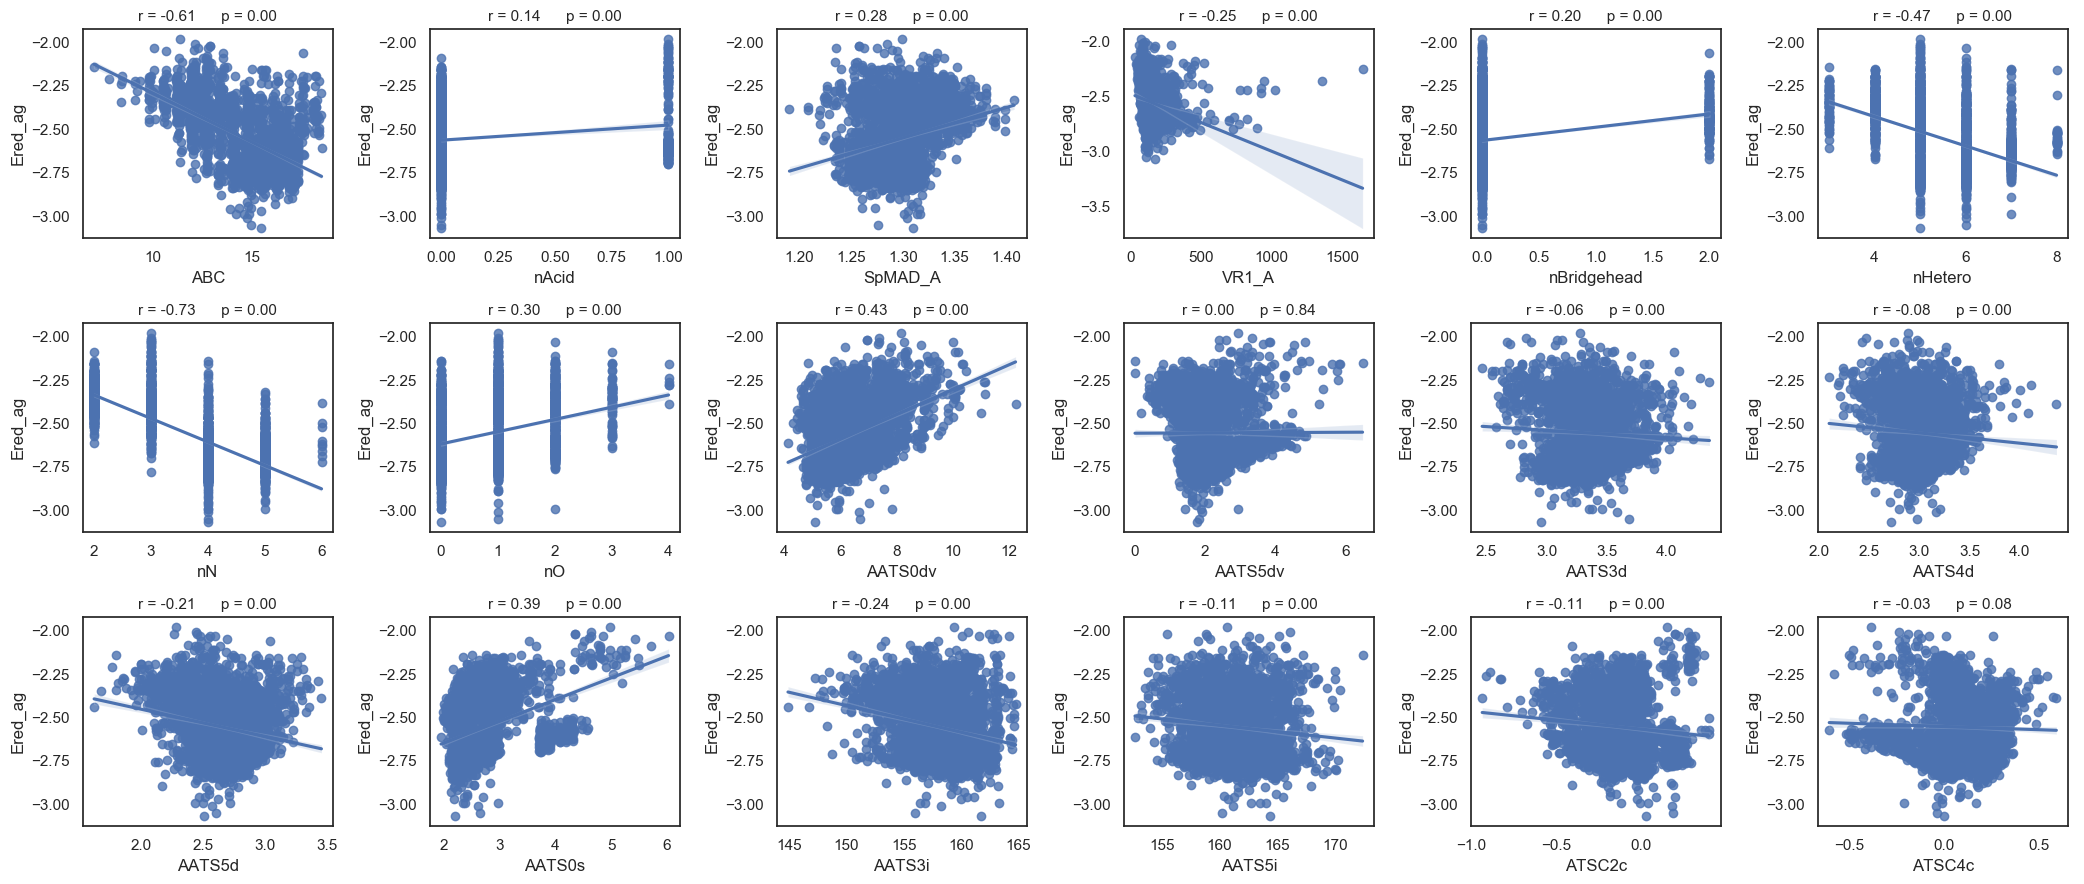

In [114]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_1to18_pearsons.png",dpi=300)
plt.show()  

# 19-36 out of the 63 features

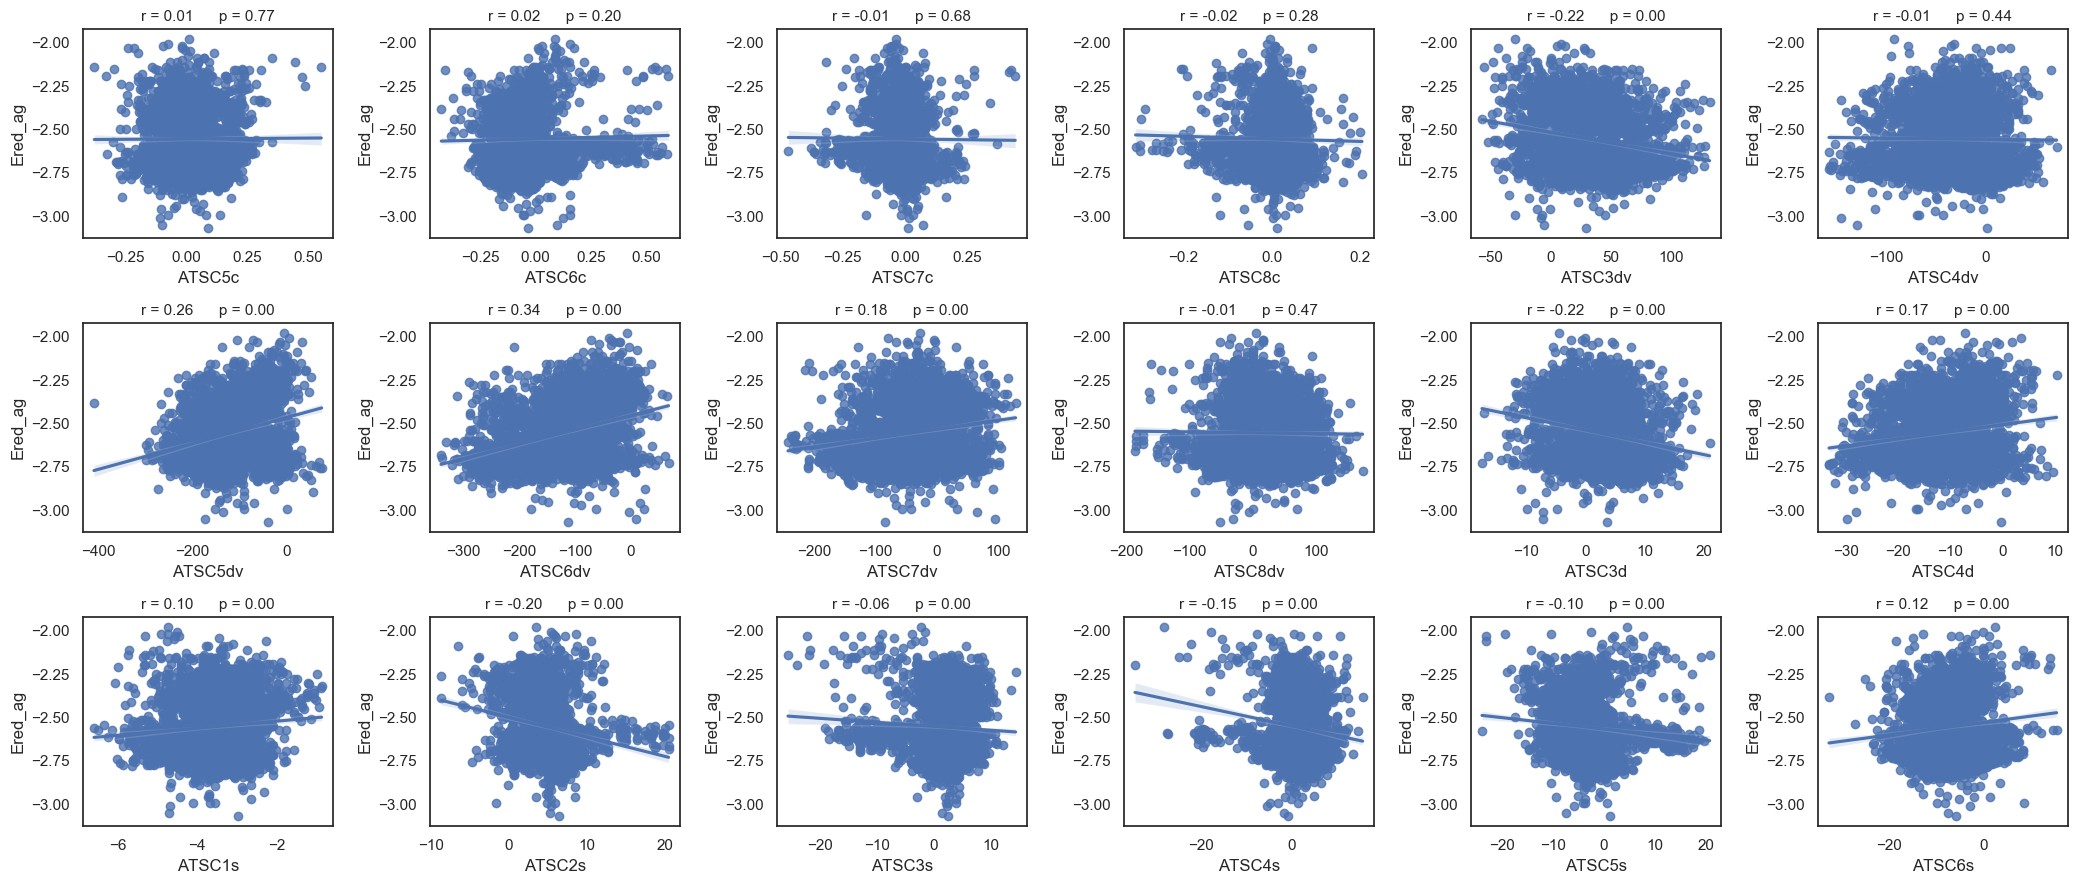

In [115]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_19to36_pearsons.png",dpi=300)
plt.show()  

# 37 to 54 out of the 63 features

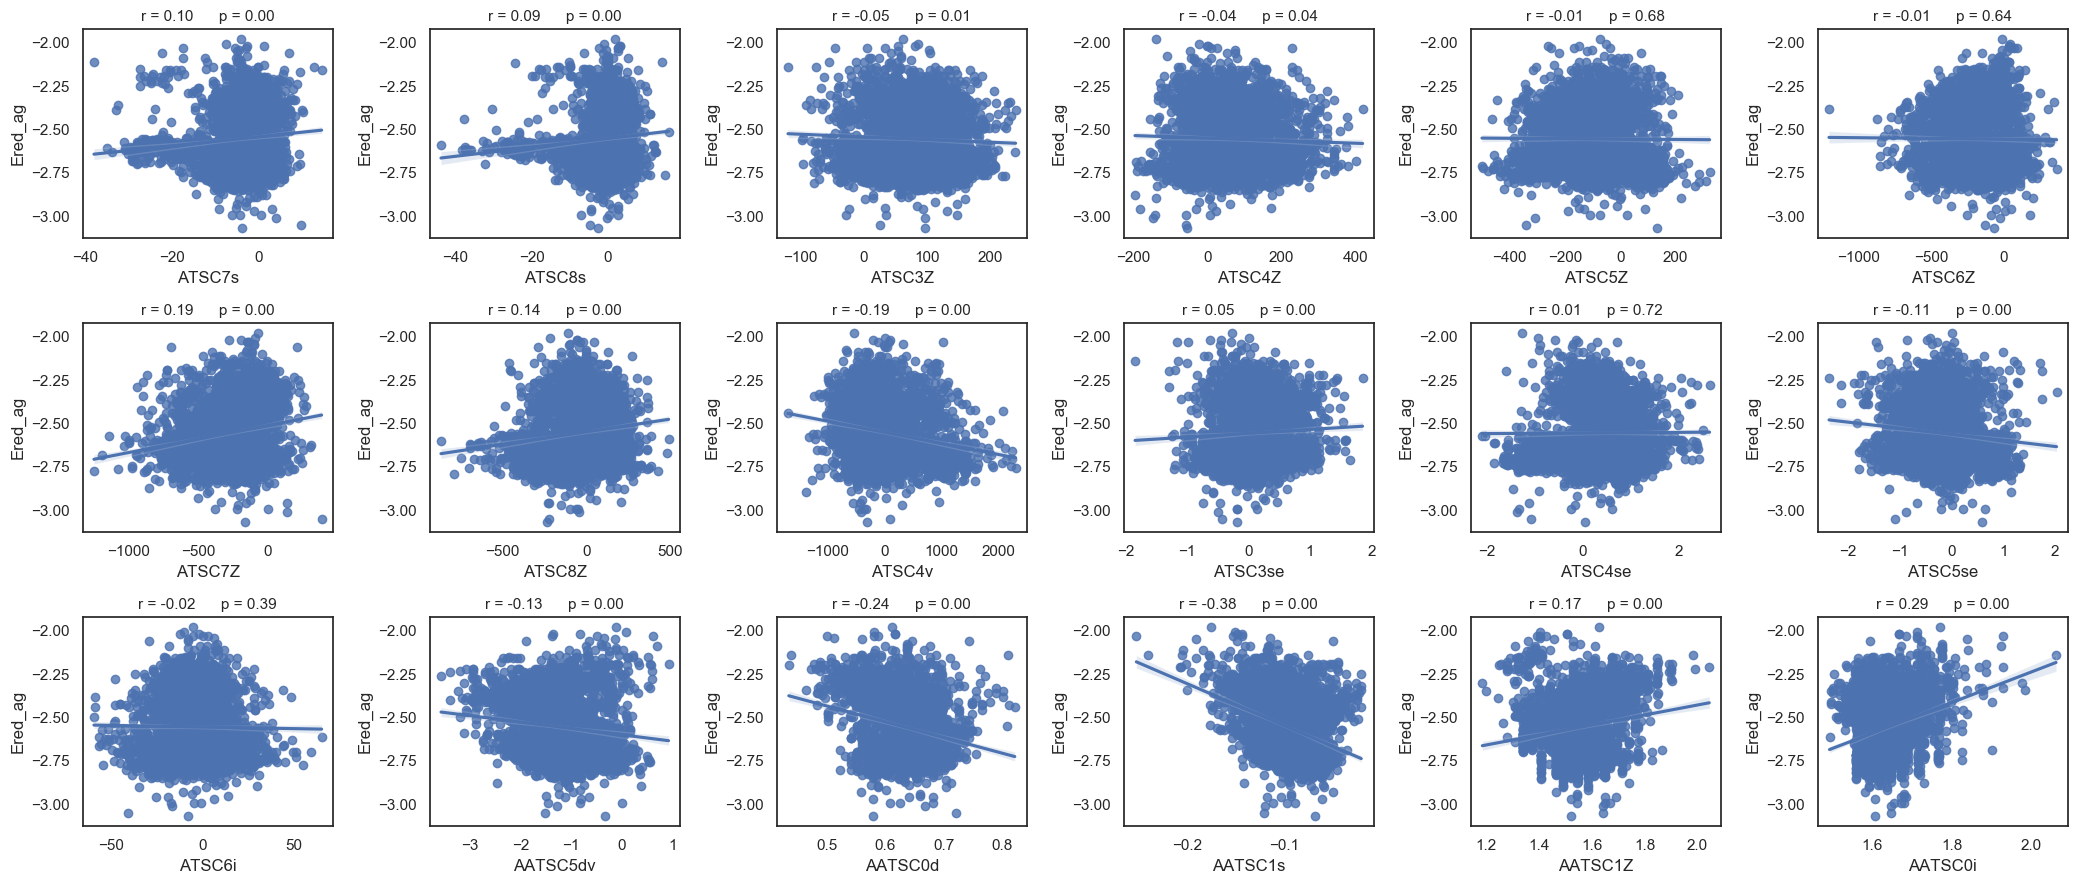

In [116]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_37to54_pearsons.png",dpi=300)
plt.show()  

# 55 to 63 out of the 63 features

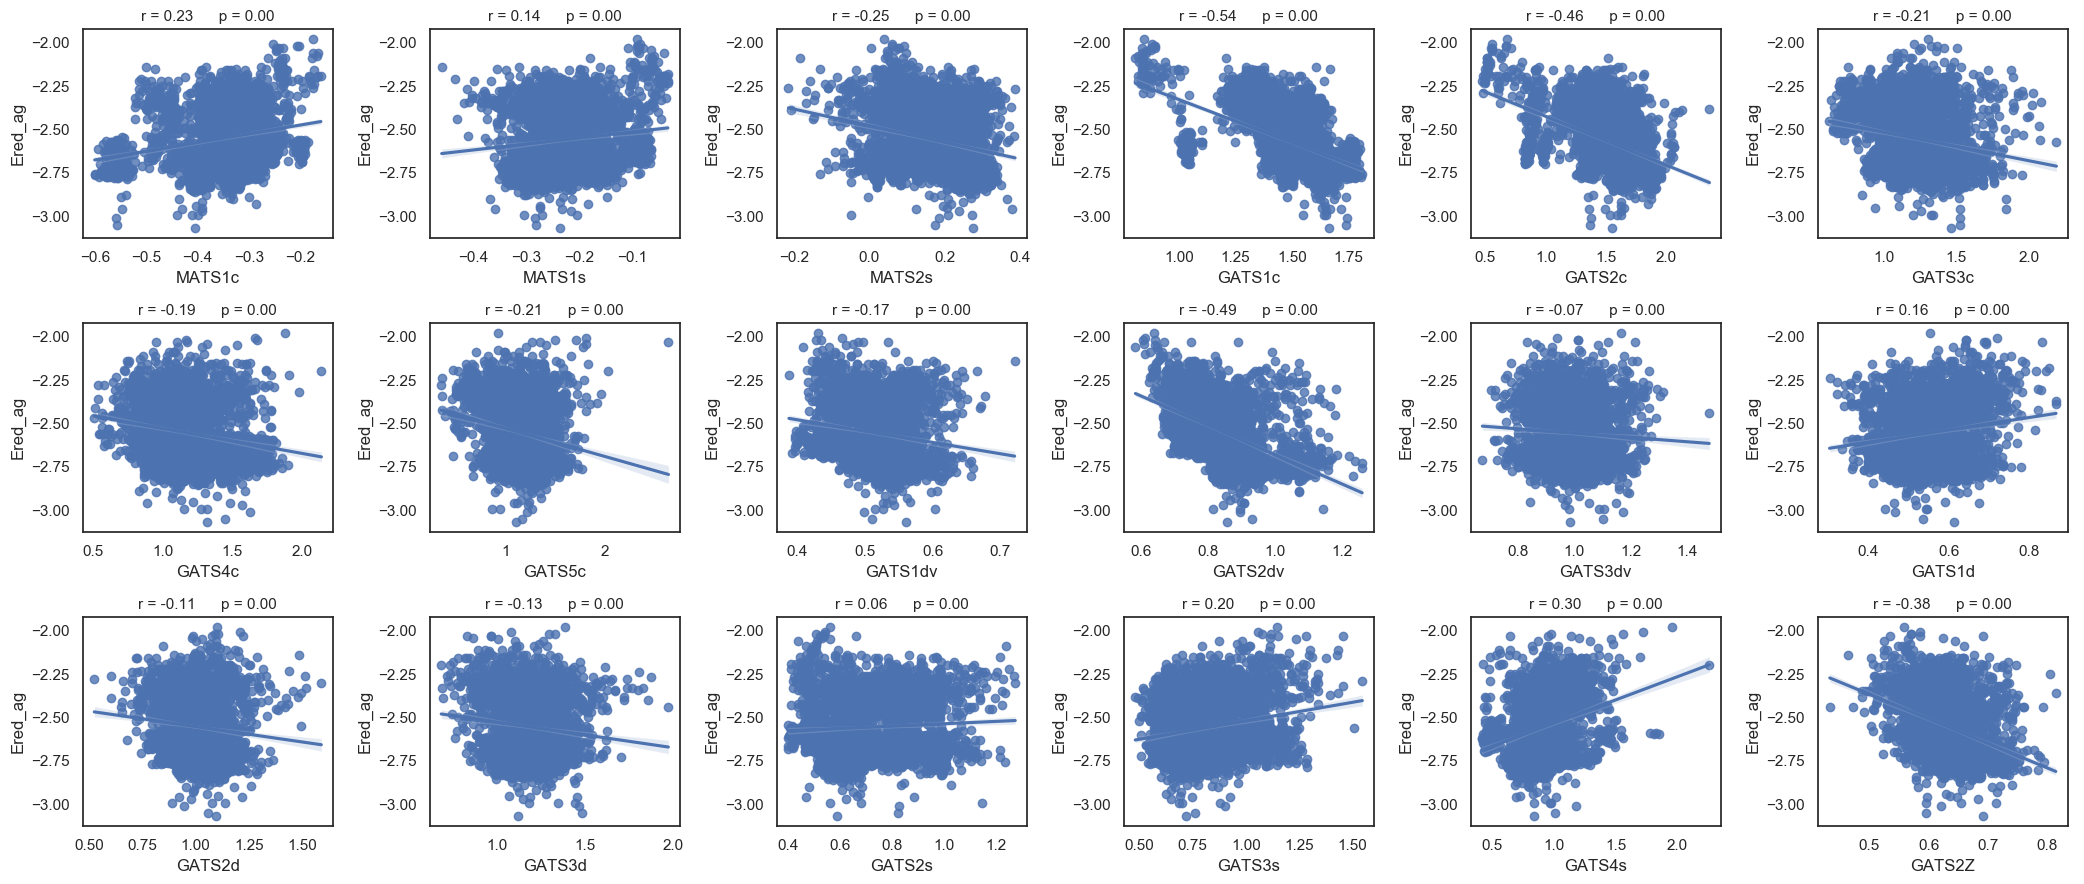

In [117]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_55to72_pearsons.png",dpi=300)
plt.show()  

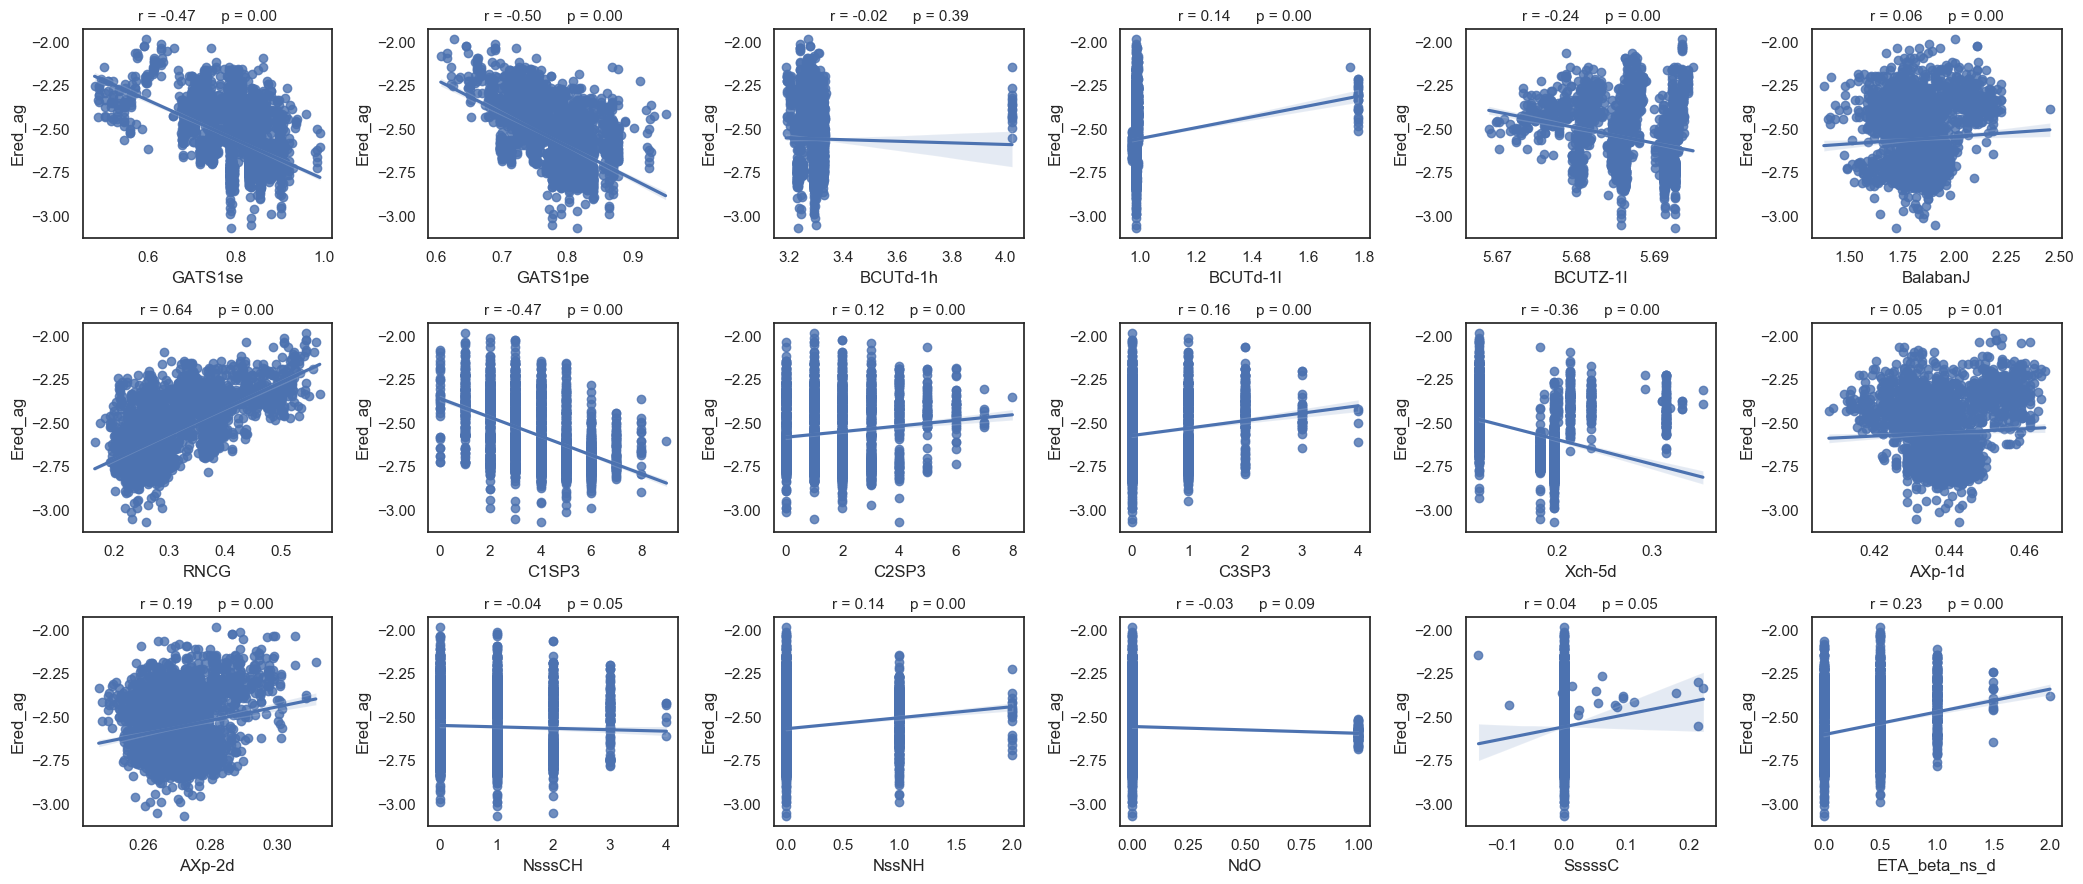

In [118]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_73to90_pearsons.png",dpi=300)
plt.show()  

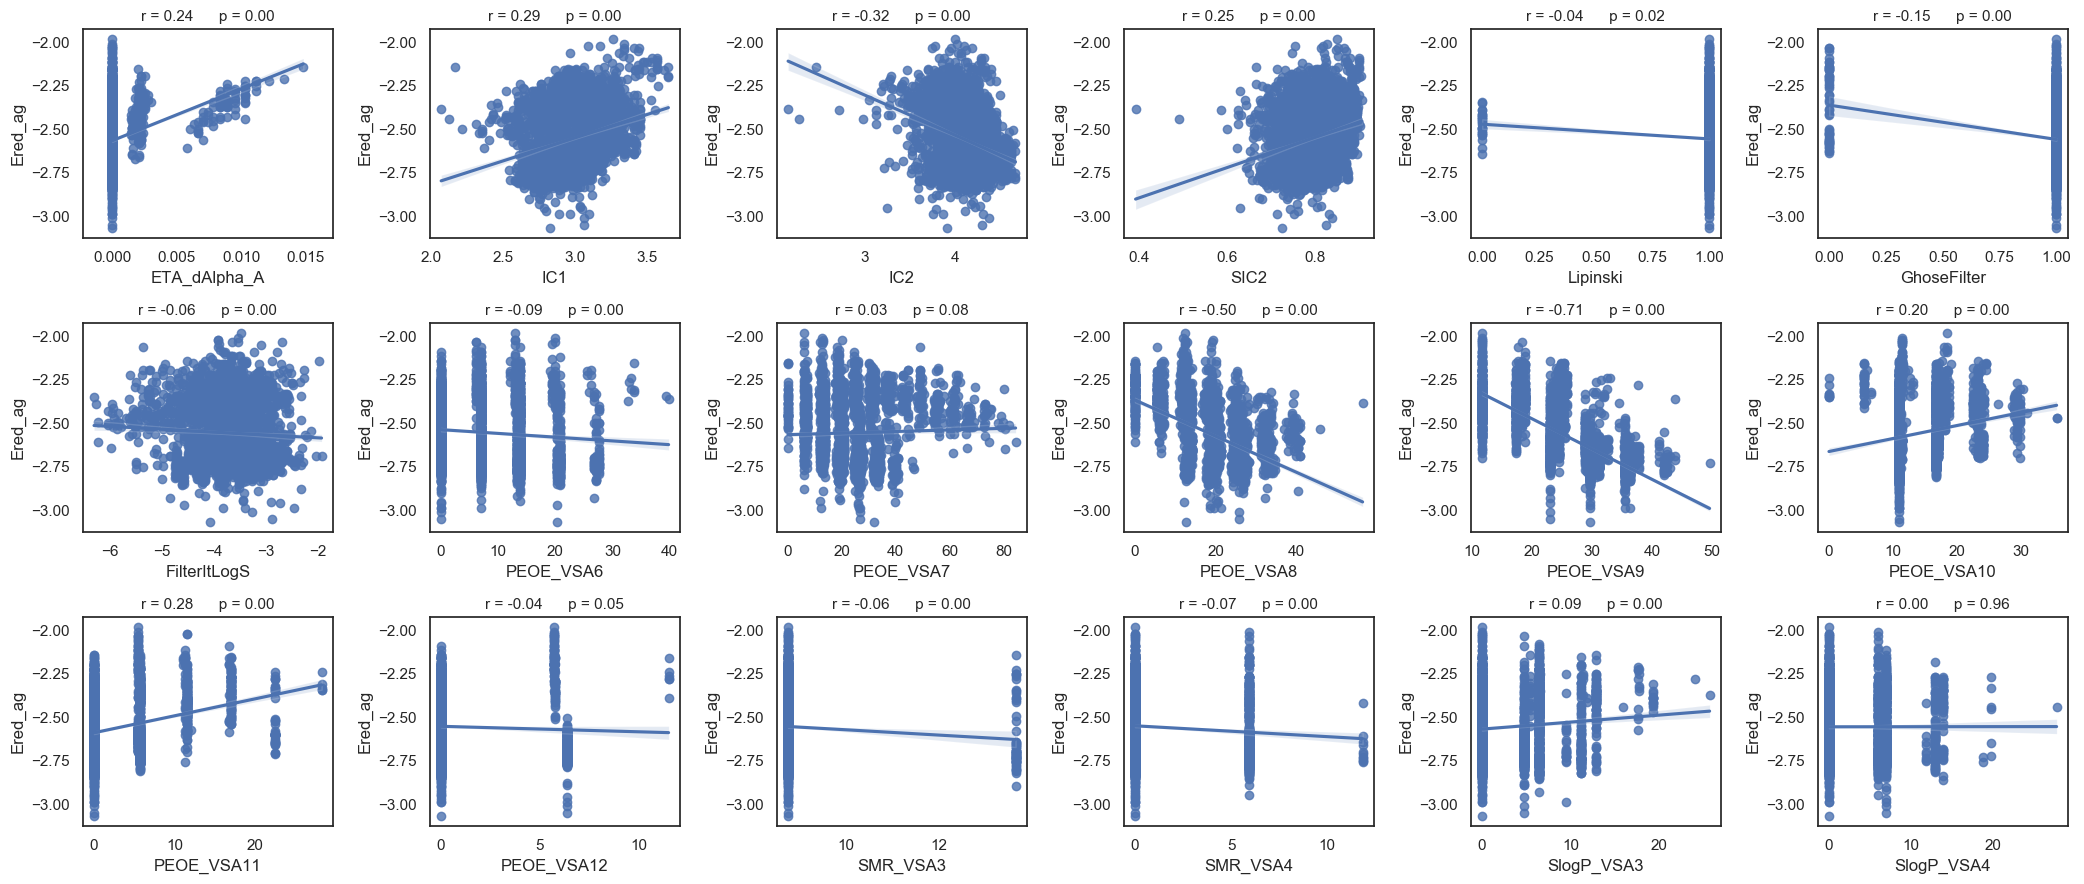

In [119]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_91to108_pearsons.png",dpi=300)
plt.show()  

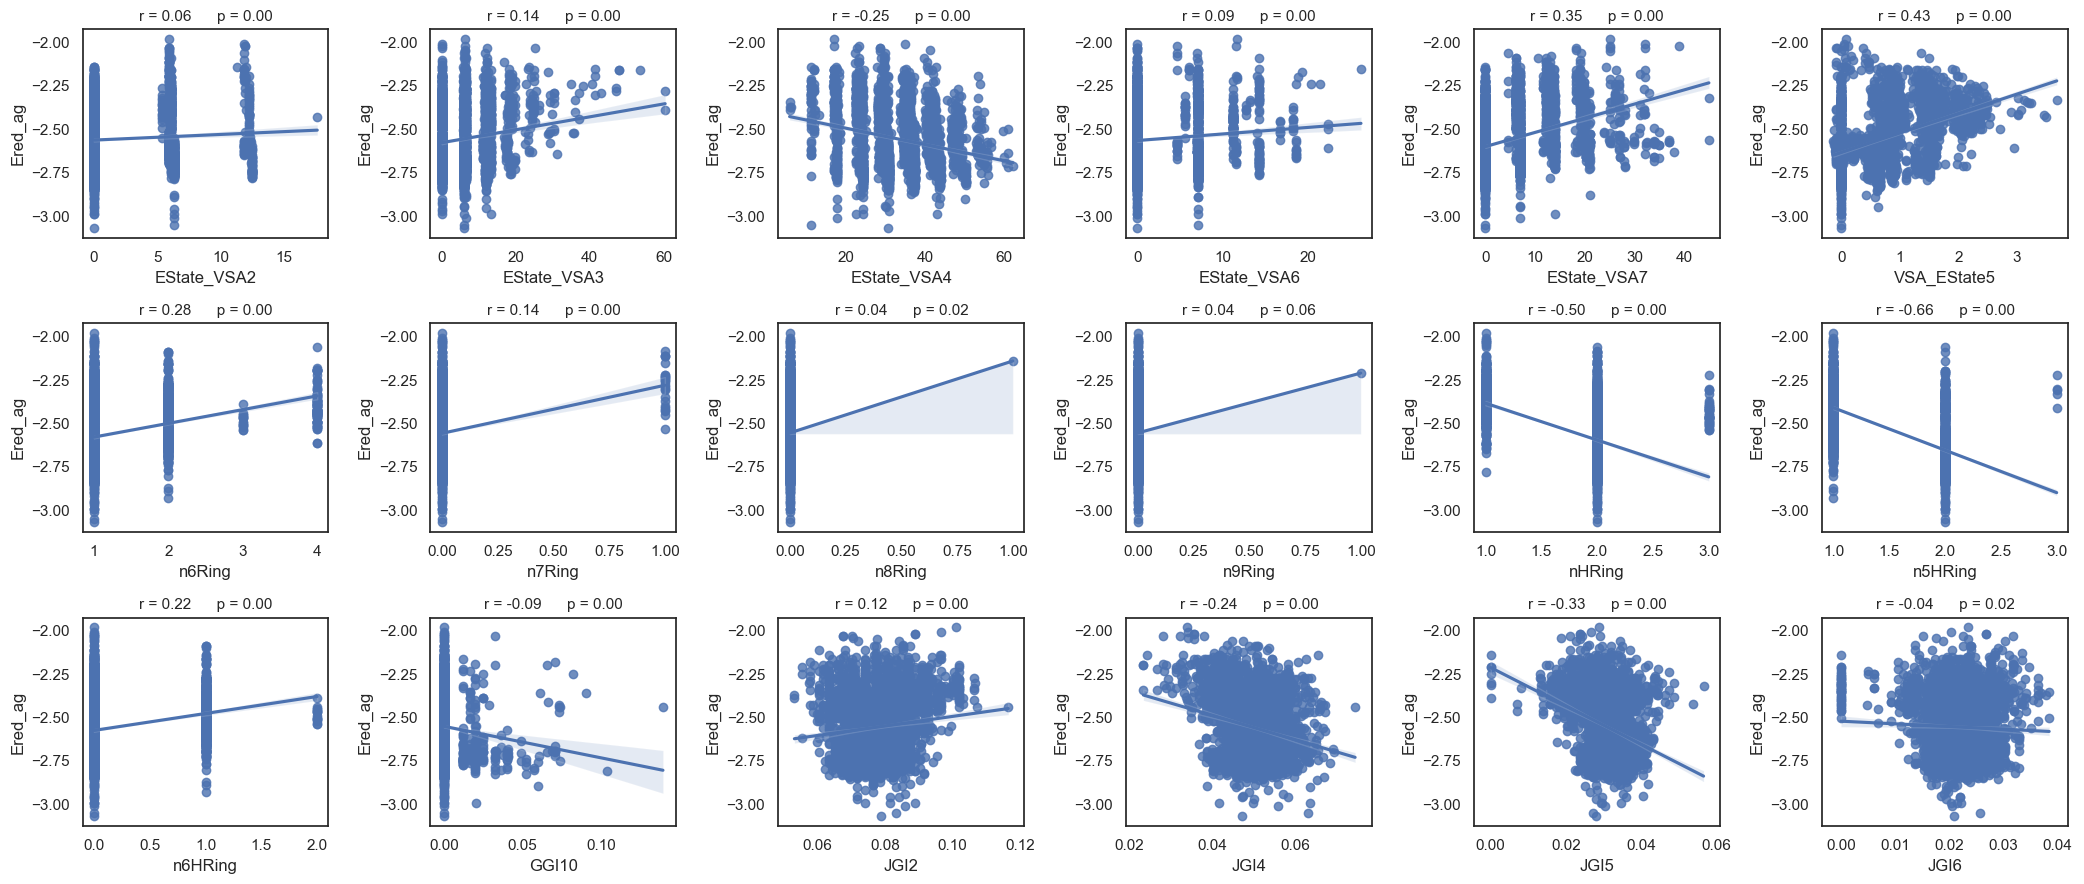

In [120]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_109to126_pearsons.png",dpi=300)
plt.show()  

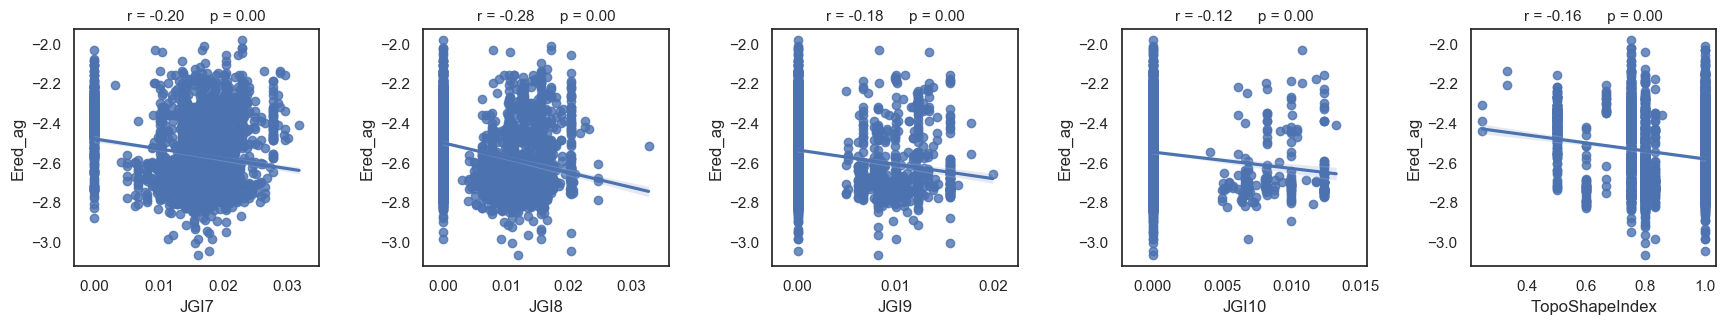

In [121]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_127to131_pearsons.png",dpi=300)
plt.show()  

# 30 (15+15) Descriptors with a high positive and negative pearson's corre. coeff.

In [122]:
corr_ered_feat=pd.DataFrame(corr_ered_feat,columns=["Descriptors","Pearsons"])

remove_desc2=[i for i,desc in enumerate(corr_ered_feat["Descriptors"]) if type(desc) is int]
corr_ered_feat=corr_ered_feat.drop(remove_desc2)
corr_ered_feat_sorted=corr_ered_feat.dropna(axis=0).sort_values("Pearsons")

# Select most dominant features

In [123]:
df_reducedDescp=pd.concat([corr_ered_feat_sorted[:15],corr_ered_feat_sorted[-15:]])

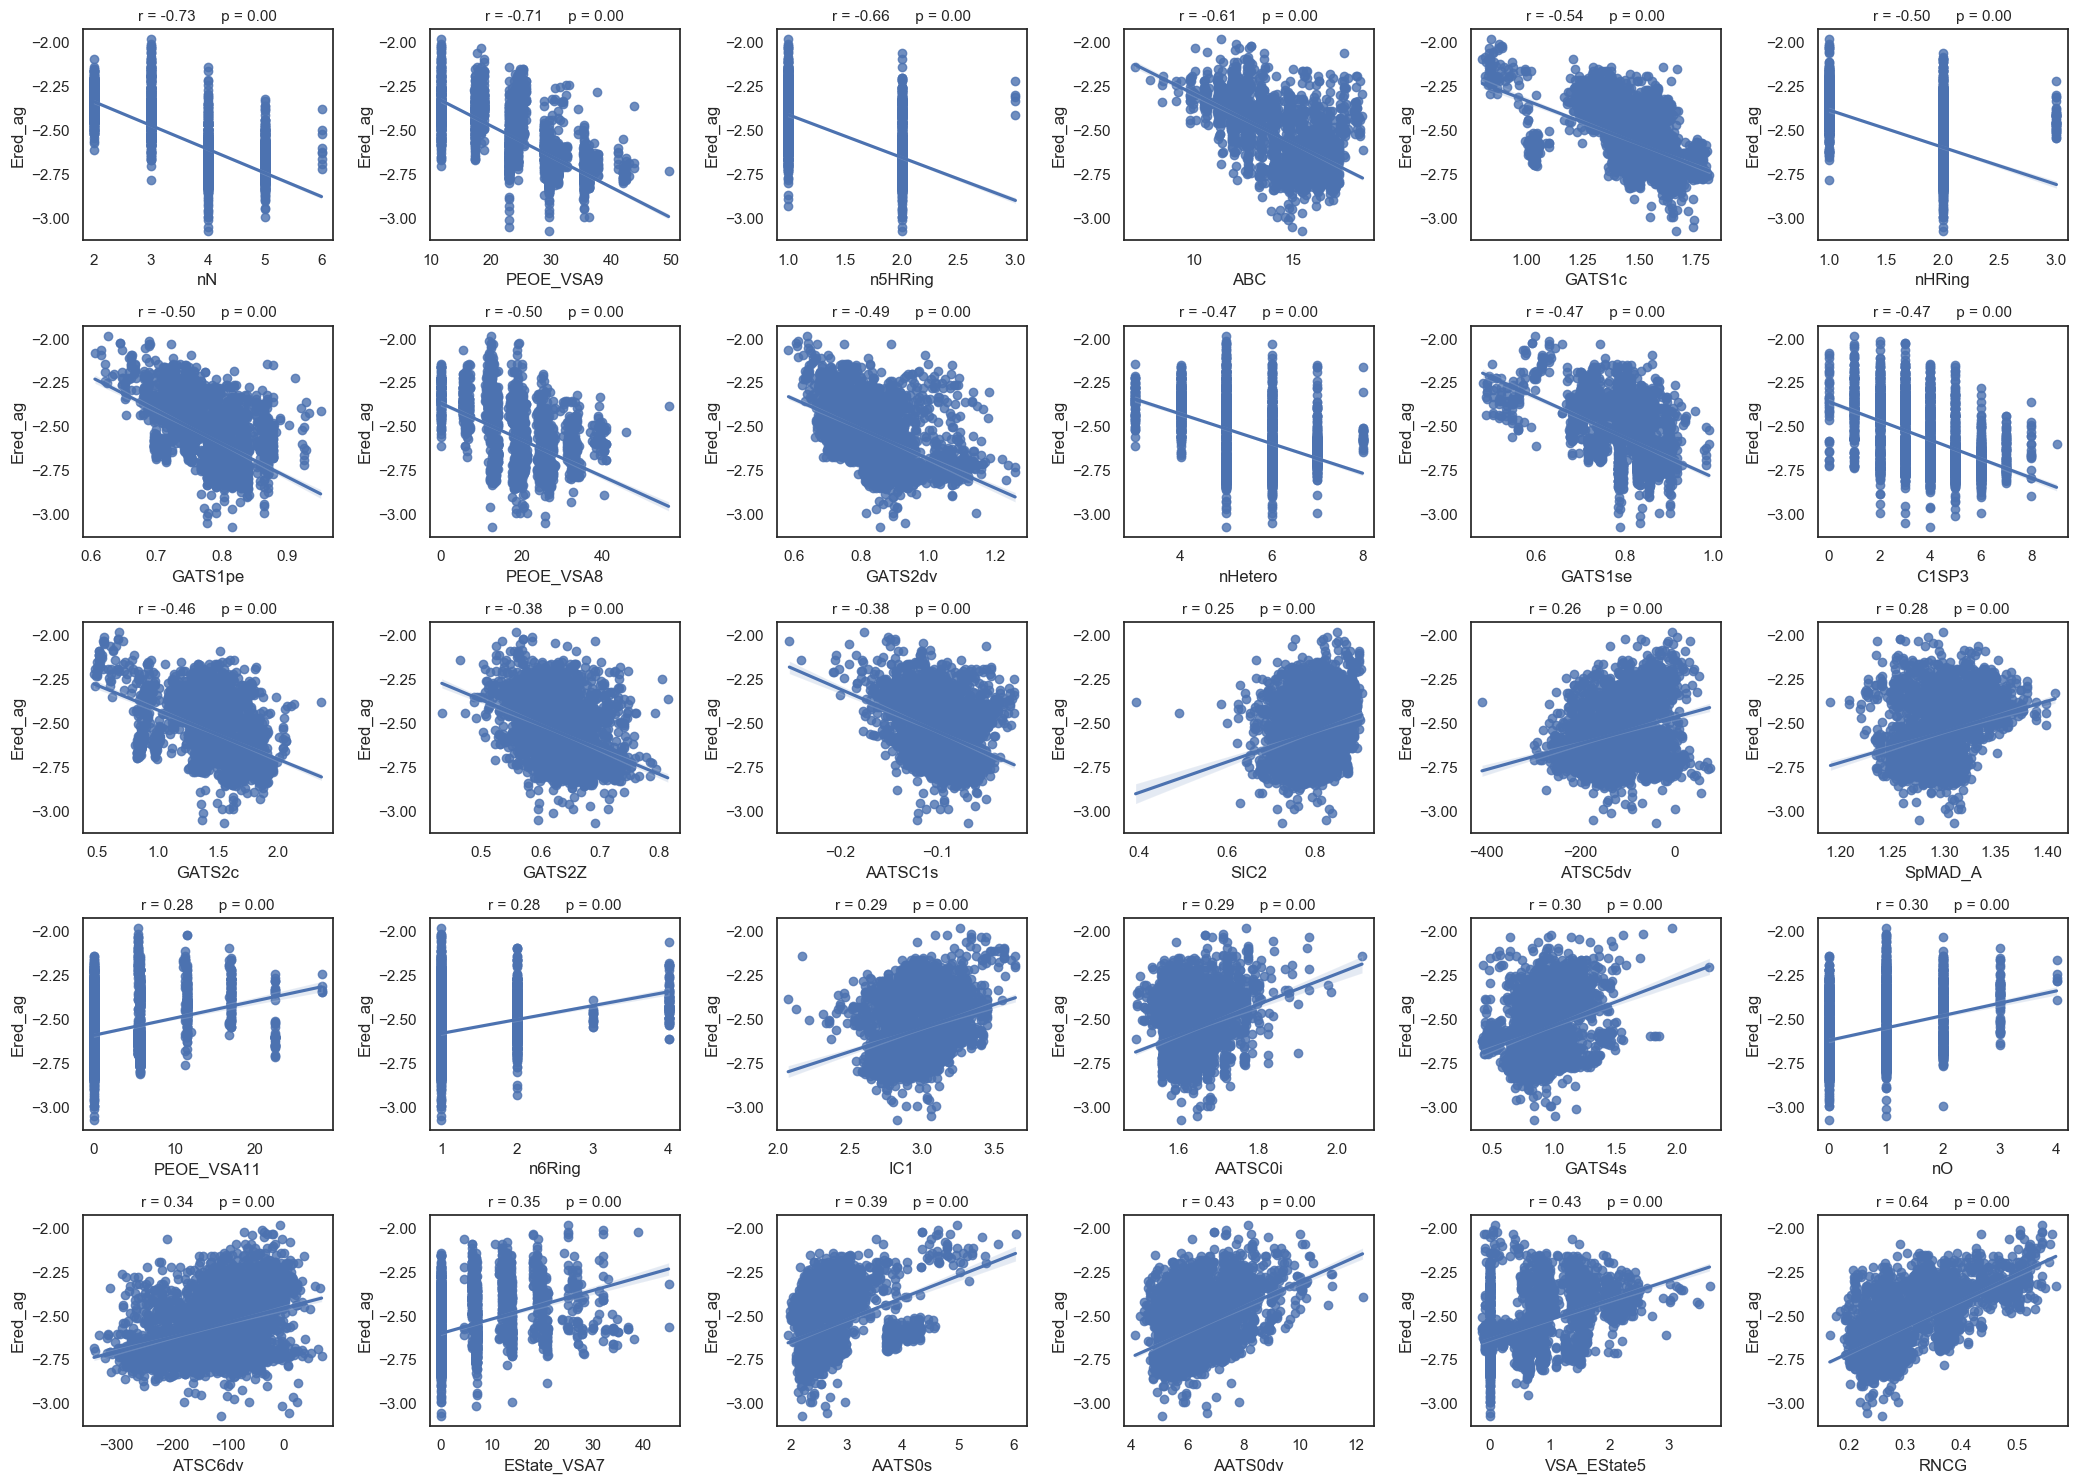

In [124]:
target = 'Ered_ag'
descriptors=df_reducedDescp.Descriptors.to_list()

nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            # print(i,descriptors[i])
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.savefig(folder_path+"Ered_and_30dominat_features.png",dpi=300)
plt.show()  

# Make two feature sets, (1) only 30 dominant features and (2) all 63 features

In [125]:
df_rdkit_uncorr_30=df_rdkit_uncorr.loc[:,df_reducedDescp["Descriptors"].to_list()]

# Check GPR model (GPytorch implementation) performance

In [126]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


import torch, gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

# Machine learning-realated functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # For normalizing inputs
from sklearn.decomposition import PCA # Principle component analysis

In [127]:
def gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1,verbose=False):
    
    """
    Gaussian Process Regression implementation with the GPyTorch
    
    Input: gpregression_pytorch(X_train,y_train,num_iter,learning_rate)
    
    Retrun: trained_model, trained_likelihood

    """
    # nfeatures=X_train.shape[1]
    train_x=torch.from_numpy(np.array(X_train))
    train_y=torch.from_numpy(np.array(y_train))
    torch.set_default_dtype(torch.float64)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
 
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else num_iter


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer # for hyperparameter tuning
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose*1*((i+1)%50==0 or i==0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, training_iter, loss.item(),model.covar_module.base_kernel.lengthscale.item(),model.likelihood.noise.item()))
            # print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (i + 1, training_iter, loss.item(),model.likelihood.noise.item()))
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    return model,likelihood

def gprediction_pytorch(model,likelihood,X_test):
    
    """
    Gaussian Process Predictions with gpr_pytorch
    
    Use: 
    model, likelihood = gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1)  
    ypred, ysigma = gprediction__pytorch(model,likelihood,X_test)

    Return: ypred and ysigma numpy arrays
    
    """
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.from_numpy(np.array(X_test))
        torch.set_default_dtype(torch.float64)
        observed_pred = likelihood(model(test_x))
        ypred = observed_pred.mean.numpy()
        ysigma = observed_pred.stddev.numpy()
    return ypred,ysigma

In [128]:
def do_pca(xtrain=None, xtest=None, rvar=None, npc=None):
    """
    Usage: do_pca(xtrain=xtrain, xtest=test) 
    Caution: Do test_train_split and scaling before pca
    Return: Transformed xtrain and xtest if they are not None
    """
    
    if xtrain is not None:
        
        pca = PCA().fit(xtrain)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if rvar is not None and npc is None:
            n_comp = 1+np.nonzero(evr > rvar)[0][0]
            print(str(n_comp)+" principal components can describe > "+ str(rvar*100)+ "% of variance in the data")
        elif rvar is None and npc is not None:
            n_comp = npc

        
        print("Selected "+str(n_comp)+" components for PCA")
        
        # col=[]
        # for i in range(1,1+n_comp,1):
        #     col.append("PC"+str(i))

        pca = PCA(n_components=n_comp)
        xtrain = pca.fit_transform(xtrain) 
        # xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=pca.transform(xtest)
            # xtest=pd.DataFrame(xtest,columns=col)
            print("returning pca transformed train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only transformed train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [129]:
from sklearn.preprocessing import StandardScaler, RobustScaler
def do_scaling(scaler=StandardScaler(), xtrain=None, xtest=None):
    """
    Usage: do_scaling(scaler=MinMaxScaler(), xtrain=xtrain, xtest=test) 
    xtrain and xtest are pd.Dataframes
    Caution: Do test_train_split before scaling
    Return: return scaled non-None xtrain and xtest
    """
    st = scaler

    if xtrain is not None:
        col=xtrain.columns.values.tolist()
        xtrain=st.fit_transform(xtrain)  
        xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=st.transform(xtest)
            xtest=pd.DataFrame(xtest,columns=col)
            print("returning scaled train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only scaled train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [130]:
def gpr_one_pytorch(X,y,train_pc=0.8):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)

    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [131]:
def plot_Ered_gpr(y_true_train,y_pred_train,y_true_test,y_pred_test,y_pred_err_train=None,y_pred_err_test=None,err_bar=False,showfig=True,savefig=False,filename="gpr_pred.png",data=True):
    """
    Return r2,rmse and mae score if data = True
    Show image if showfig=True
    Save image if savefig=True
    """
    
    mae_train = round(MAE(y_true_train,y_pred_train),2)
    r2_train = round(r2_score(y_true_train,y_pred_train),2)
    rmse_train = round(np.sqrt(MSE(y_true_train,y_pred_train)),2)

    mae_test = round(MAE(y_true_test,y_pred_test),2)
    r2_test = round(r2_score(y_true_test,y_pred_test),2)
    rmse_test = round(np.sqrt(MSE(y_true_test,y_pred_test)),2)
     
    if showfig:
        plt.figure(figsize=(6, 6)) 
        plt.tick_params(reset=True)

        if err_bar*(y_pred_err_train is not None):
            plt.errorbar(y_true_train,y_pred_train,yerr=y_pred_err_train,color="red",fmt='o',label="Train")

        if err_bar*(y_pred_err_test is not None):
            plt.errorbar(y_true_test,y_pred_test,yerr=y_pred_err_test,color="blue",fmt='o',label="Test")

        plt.plot([y_true_train.min()-0.2,y_true_train.max()+0.2],[y_true_train.min()-0.2,y_true_train.max()+0.2],color='black')
        
        string=f"$R^2$={r2_train:0.2f}, RMSE = {rmse_train:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.03,string,color='red')
        

        string=f"$R^2$={r2_test:0.2f}, RMSE = {rmse_test:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.15,string,color="blue")

        plt.rc('font', size=20)
        plt.xlabel('DFT calculated values (V)')
        plt.ylabel('GPR Predicted values (V)')
        plt.xlim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.ylim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.xticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))        
        plt.yticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))
        
        plt.legend(loc='lower right') #best
        plt.tight_layout()
        
        if savefig:
            plt.savefig(filename,dpi=300,bbox_inches='tight')
        plt.show()


    if data:
        return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

# with all 131 features (no PCA for now)
## 80% train and 20% test data

In [132]:
X=df_rdkit_uncorr
y=ERed_data["Ered_ag"]
# 
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pytorch(X=X,y=y,train_pc=0.8)


returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


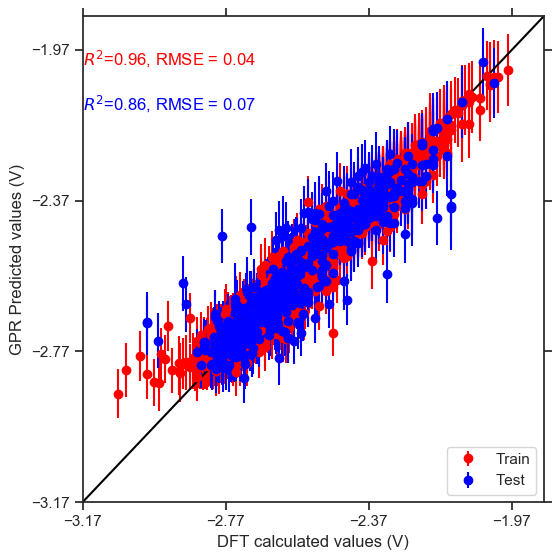

In [133]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,filename=folder_path+"GPR_noPCA_63feat.png",data=False)

# With only 30 dominant features (no PCA)
# 80%-20% train-test split

In [134]:
X=df_rdkit_uncorr_30
y=ERed_data["Ered_ag"]
# 
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pytorch(X=X,y=y,train_pc=0.8)


returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


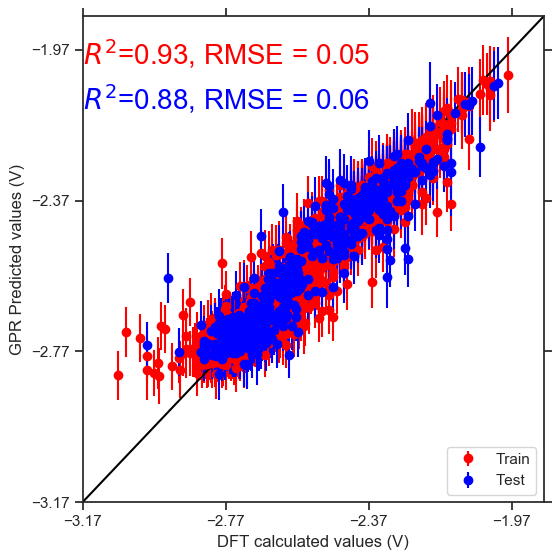

In [135]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,filename=folder_path+"GPR_noPCA_30feat.png",data=False)

# PCA with all 131 features  

In [136]:
# del X, X_st, pca

test data is not provided, returning only scaled train data


C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.995029                                                                        
2                   0.995679                                                                        
3                   0.996217                                                                        
4                   0.996667                                                                        
5                   0.997062                                                                        
6                   0.997433                                                                        
7                   0.997774                                                                        
8                   0.998086                                                                        
9                   0.998313            

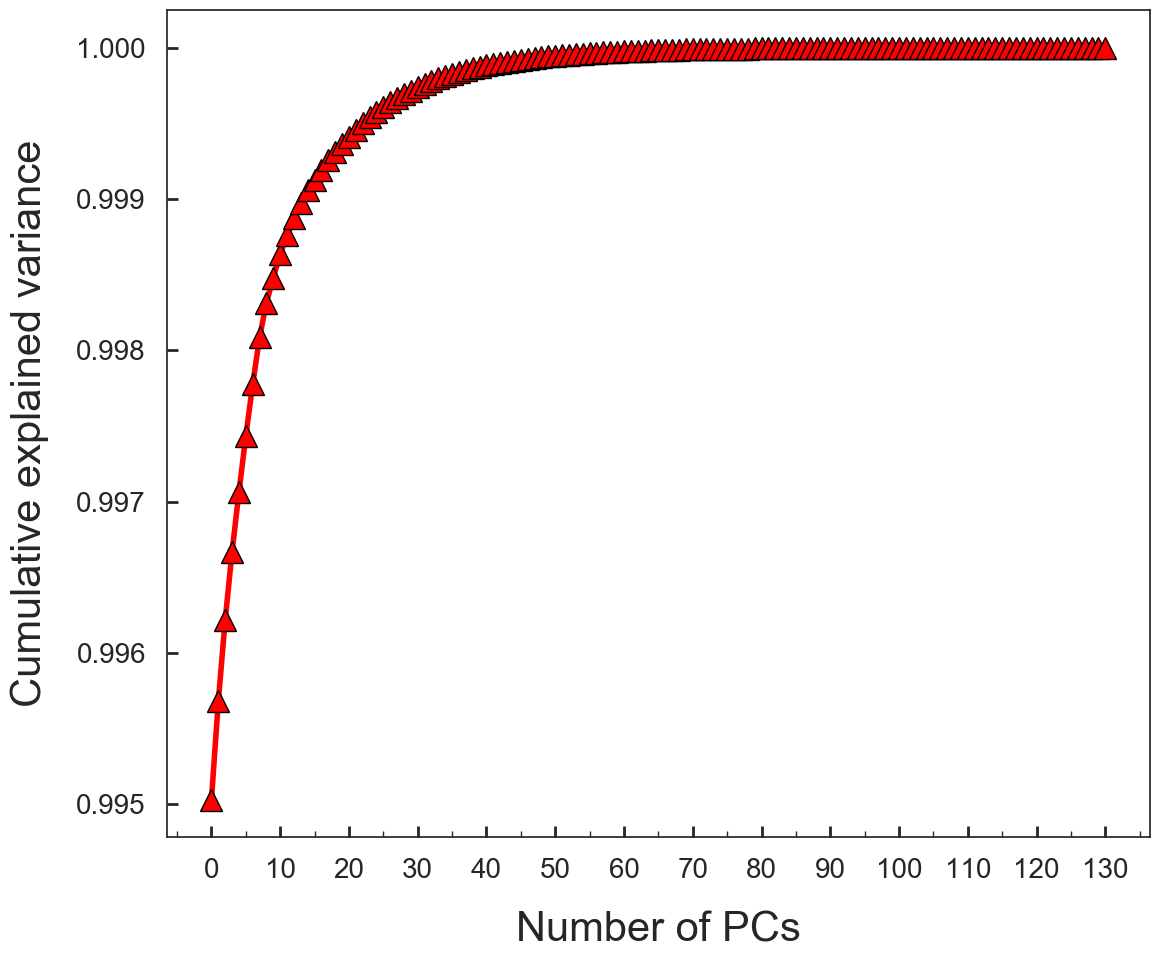

In [137]:
from sklearn.decomposition import PCA # Principle component analysis
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)


X=df_rdkit_uncorr

X_st= do_scaling(scaler=RobustScaler(),xtrain=X, xtest=None)
pca = PCA().fit(X_st)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
plt.savefig(folder_path+"pca_63features.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# PCA with 30 features 

In [138]:
del X, X_st, pca

test data is not provided, returning only scaled train data


C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.310326                                                                        
2                   0.493103                                                                        
3                   0.596408                                                                        
4                   0.666593                                                                        
5                   0.732128                                                                        
6                   0.777090                                                                        
7                   0.816165                                                                        
8                   0.853006                                                                        
9                   0.876825            

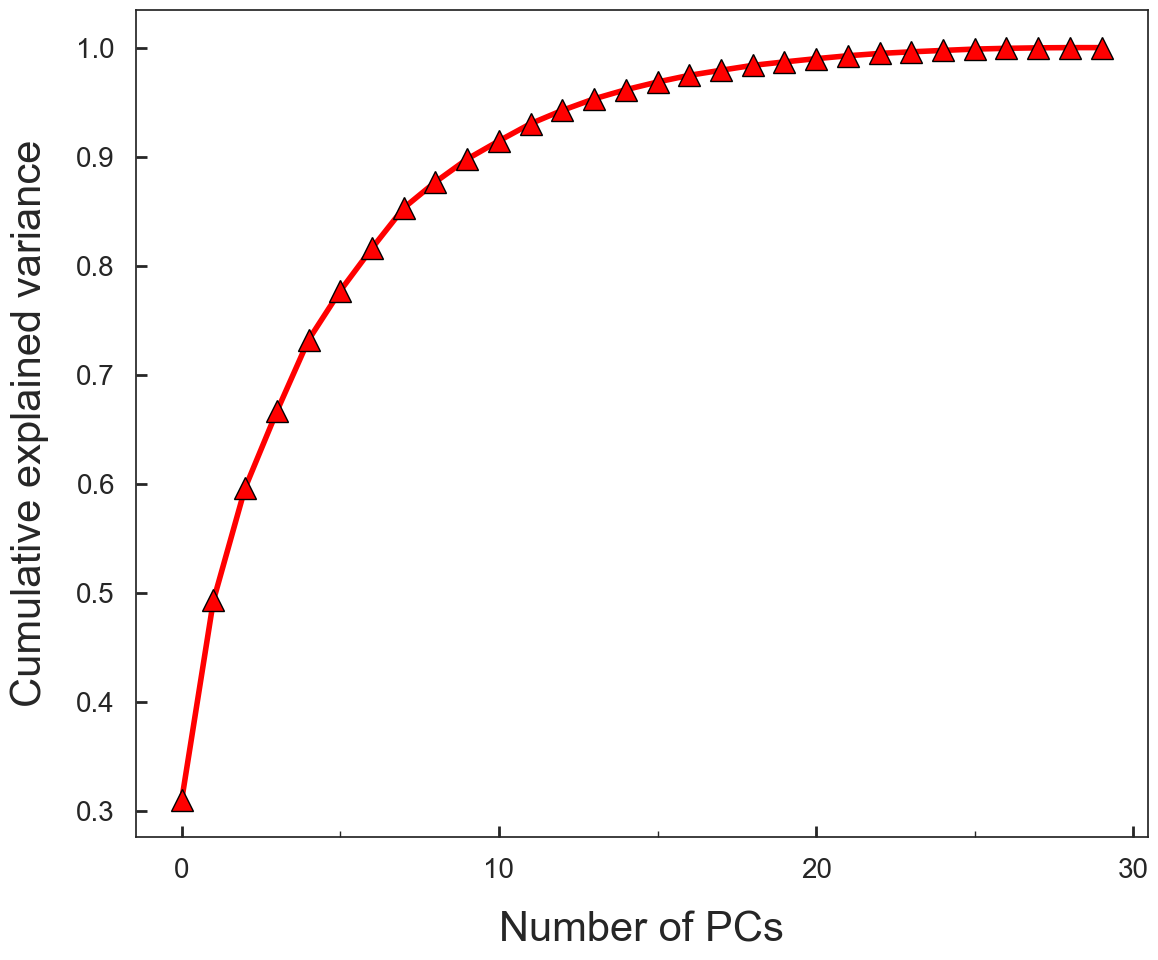

In [139]:
X=df_rdkit_uncorr_30

X_st= do_scaling(scaler=RobustScaler(),xtrain=X, xtest=None)
pca = PCA().fit(X_st)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
plt.savefig(folder_path+"pca_30features.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# Distribution of Ered as a function of the 1st and 2nd PCs that describe most cumulative variance

## PCA with all 63 features

In [140]:
n_PC = 16  # Set number of principle components
pca = PCA(n_components=n_PC)
del X
X=df_rdkit_uncorr.copy()
X=do_scaling(xtrain=X)
Xdata = pca.fit_transform(X)  # Transform feature vectors to PCs

test data is not provided, returning only scaled train data


In [141]:
col_txt=["PC"+str(i+1) for i in np.arange(n_PC)]
df_xdata=pd.DataFrame(Xdata,columns=col_txt)
df_xdata.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.165421  0.583751 -4.066101 -4.470510  3.369968  1.912458 -2.898499   
1  0.047848  1.476221 -1.076347 -3.992700  4.142106 -2.046299 -2.408150   
2 -2.493659 -1.097562 -0.645017 -3.688416 -0.237334  3.752301 -1.537787   
3 -4.011038 -3.104152 -0.991132 -3.228958  1.862483  1.072268 -0.580574   
4 -2.584517 -2.593082 -1.611334 -3.691110 -0.019385  3.084685 -0.884275   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -2.686904  0.469734  1.631182  3.991378  2.235699 -1.896540  1.727933   
1  0.356269  0.830985  1.261974  3.439103  0.127508  0.652855  1.960503   
2  2.046022  3.521612  0.008055  1.240744  1.916475  2.053055 -0.436191   
3  5.181306  2.187472 -0.649794  1.385300  1.258535  1.952207  0.212485   
4  3.728342  3.975892  0.217987  1.855042  1.246602  1.318922 -0.368314   

       PC15      PC16  
0 -1.028074  1.366565  
1 -2.402933  1.563939  
2  0.137509  0.799639  
3 -0.622574  1.103818  
4 -0.231274  1.153884

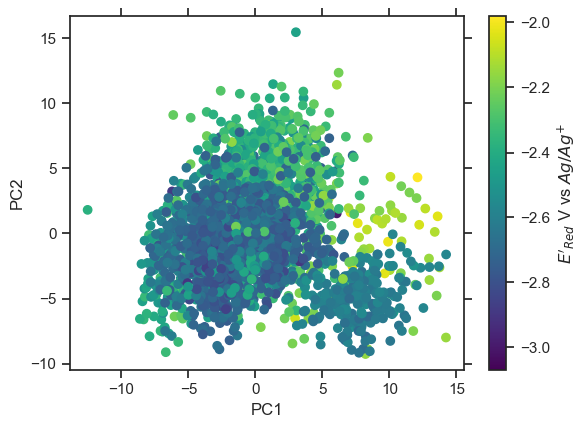

In [142]:
plt.tick_params(reset=True)
plt.scatter(x=df_xdata.PC1,y=df_xdata.PC2,c=ERed_data.Ered_ag,cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.rc('font', size=24) 
plt.colorbar(label="$E\'_{Red}$ V vs $Ag/Ag^{+}$")

plt.tight_layout()
plt.savefig(folder_path+"PC1_PC2_ERed_Ag_with63feat_PCA.png",dpi=300)
plt.show()

# PCA with 30feat

In [143]:
n_PC = 16  # Set number of principle components
pca = PCA(n_components=n_PC)
del X
X=df_rdkit_uncorr_30.copy()
X=do_scaling(xtrain=X)
Xdata = pca.fit_transform(X)  # Transform feature vectors to PCs

test data is not provided, returning only scaled train data


In [144]:
col_txt=["PC"+str(i+1) for i in np.arange(n_PC)]
df_xdata_30=pd.DataFrame(Xdata,columns=col_txt)
df_xdata_30.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -4.089775  0.291194 -1.370586 -1.525070  0.893351 -2.448827  0.922212   
1 -3.125900 -0.327194 -0.428249 -2.410055  2.047677 -1.962990 -0.229213   
2 -3.993193  0.042184 -0.424176 -0.365109 -0.106220 -1.087232  2.236660   
3 -5.010640  0.977685  0.289394 -0.445655  0.681872 -1.320323  1.558098   
4 -4.890822  0.769890  0.189374  0.196746  0.208643 -1.434184  1.819969   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.210066  2.408925  0.946578 -1.037024 -0.267930  0.511717  0.225180   
1 -0.188136  1.957965 -0.435336 -1.188680 -0.564185  0.837739  0.045692   
2  1.308579  0.544000 -0.858829 -0.334325  0.461978  0.440936  0.108468   
3  1.761074  0.850676 -0.899318 -0.678565  1.170707  0.687438  0.150705   
4  1.678264  1.190598 -1.014541 -0.518827  1.239234  0.448194  0.275550   

       PC15      PC16  
0 -0.762120  0.731639  
1  0.745597 -0.366034  
2 -0.125731 -0.252493  
3  0.903346  0.183159  
4  0.621232  0.018789

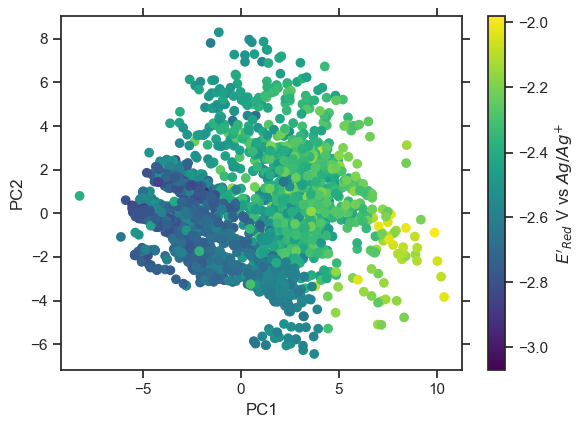

In [145]:
plt.tick_params(reset=True)
plt.scatter(x=df_xdata_30.PC1,y=df_xdata_30.PC2,c=ERed_data.Ered_ag,cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.rc('font', size=24) 
plt.colorbar(label="$E\'_{Red}$ V vs $Ag/Ag^{+}$")

plt.tight_layout()
plt.savefig(folder_path+"PC1_PC2_ERed_Ag_with30feat_PCA.png",dpi=300)
plt.show()

Similar distribution of Ered with the PCs of both 30 and 63 features

# Learning curves for num_PCs and train-test split%
## 17 or more PCs made with 30 dominant features can describe at least 99% cumulative variance in data
## 29 or more PC made with 63 features can describe at least 99% cumulative variance in data
## Hence, using only 30 dominant features to obtain learning curves


In [146]:
def gpr_one_pca_pytorch(X,y,train_pc=0.8,nPC=5,random_state=None):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc,random_state=random_state) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)
    # PCA
    n_PC = nPC  # Set number of principle components
    pca = PCA(n_components=n_PC)
        
    xtrain = pca.fit_transform(xtrain) 
    xtest=pca.transform(xtest)
    # print(f"xtrain.shape={xtrain.shape},xtest.shape={xtest.shape}")
    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [147]:
def helper(X,y,nPC=5,train_pc=0.8,random_state=None):
    y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=train_pc,nPC=nPC,random_state=random_state)
    r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train=plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=False,savefig=False,data=True)
    return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

In [148]:
train_pcs = [0.2, 0.4, 0.6, 0.8 , 0.9]
num_PCs = [5, 10, 17, 25, df_rdkit_uncorr_30.shape[1]]

In [149]:
train_pcs_avg_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_avg_test_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_test_score=np.zeros([len(train_pcs),len(num_PCs),3])

# Be patient next block of code will take time to complete
## will repeat experiments 10 times to get statistics

In [150]:
from tqdm import tqdm
import time

In [151]:
%%capture
repeats=10
for jdx,tr_pc in enumerate(tqdm(train_pcs,position=0, desc="train_pcs", leave=False, colour='green', ncols=80)):

    avg_train_score = np.zeros([len(num_PCs),3])
    avg_test_score = np.zeros([len(num_PCs),3])

    std_train_score = np.zeros([len(num_PCs),3])
    std_test_score = np.zeros([len(num_PCs),3])

    for idx,PCs in enumerate(tqdm(num_PCs,position=1,desc="num_PCs", leave=False, colour='blue', ncols=80)):

        X=df_rdkit_uncorr_30
        y=ERed_data.Ered_ag.to_list()
        
        
        r2_train,rmse_train,mae_train=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)
        r2_test,rmse_test,mae_test=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)

        for j in tqdm(np.arange(repeats),position=2,desc="repeats",leave=False,colour="red",ncols=80):
            # print(f" ---> %repeat <-- ={100*j/repeats}")
            r2_test[j],rmse_test[j],mae_test[j],r2_train[j],rmse_train[j],mae_train[j]=helper(X=X,y=y,nPC=PCs,train_pc=tr_pc)

        avg_test_score[idx] = r2_test.mean(),rmse_test.mean(),mae_test.mean()
        avg_train_score[idx] = r2_train.mean(),rmse_train.mean(),mae_train.mean()
        std_test_score[idx] = r2_test.std(),rmse_test.std(),mae_test.std()
        std_train_score[idx] = r2_train.std(),rmse_train.std(),mae_train.std()

    # store scores for each tr_pc
    train_pcs_avg_train_score[jdx] = avg_train_score
    train_pcs_avg_test_score[jdx] = avg_test_score
    train_pcs_std_train_score[jdx] = std_train_score
    train_pcs_std_test_score[jdx] = std_test_score

# Plot curves

In [152]:
y_r2_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_4pc=[train_pcs_std_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_4pc=[train_pcs_std_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_4pc=[train_pcs_std_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_8pc=[train_pcs_std_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_8pc=[train_pcs_std_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_8pc=[train_pcs_std_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_16pc=[train_pcs_std_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_16pc=[train_pcs_std_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_16pc=[train_pcs_std_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_32pc=[train_pcs_std_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_32pc=[train_pcs_std_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_32pc=[train_pcs_std_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_46pc=[train_pcs_std_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_46pc=[train_pcs_std_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_46pc=[train_pcs_std_train_score[x][4][2] for x in np.arange(len(train_pcs))]

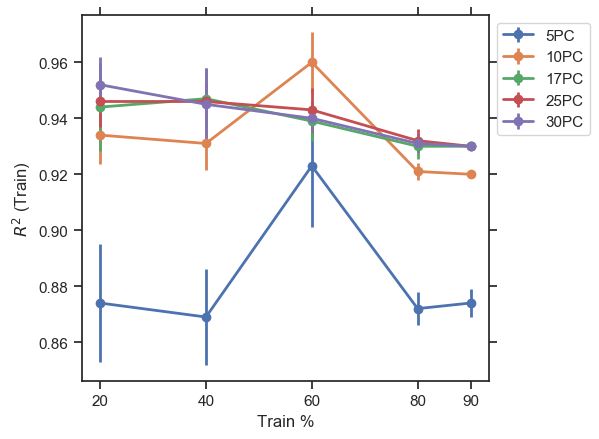

In [153]:
plt.tick_params(reset=True)
# plt.rcParams['ytick.labelsize'] = 25
# plt.rc('font', size=20) 
# plt.figure(figsize=(4,6))
train_pcs=np.array(train_pcs)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_4pc,yerr=y_r2_std_tr_10_4pc,label="5PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_8pc,yerr=y_r2_std_tr_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_16pc,yerr=y_r2_std_tr_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_32pc,yerr=y_r2_std_tr_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_46pc,yerr=y_r2_std_tr_10_46pc,fmt='-o',label=f"30PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Train)")
plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"r2_train_learning_curve_train_test_30feat_PCA.png",dpi=300)

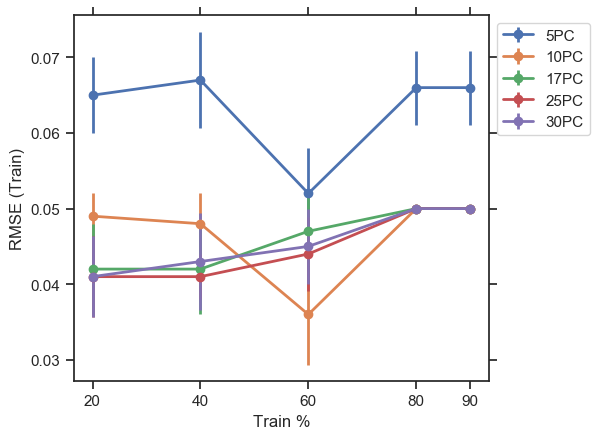

In [154]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_tr_10_4pc,yerr=y_rmse_std_tr_10_4pc,label="5PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_8pc,yerr=y_rmse_std_tr_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_16pc,yerr=y_rmse_std_tr_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_32pc,yerr=y_rmse_std_tr_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_46pc,yerr=y_rmse_std_tr_10_46pc,fmt='-o',label="30PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Train)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"rmse_train_learning_curve_train_test_30feat_PCA.png",dpi=300)

In [155]:
# save numpy array as npy file
from numpy import asarray
from numpy import save

# save to npy file
save(folder_path+'train_pcs_avg_test_score.npy', train_pcs_avg_test_score)
save(folder_path+'train_pcs_avg_train_score.npy', train_pcs_avg_train_score)
save(folder_path+'train_pcs_std_test_score.npy', train_pcs_std_test_score)
save(folder_path+'train_pcs_std_train_score.npy', train_pcs_std_train_score)

In [156]:
# # load numpy array from npy file
# from numpy import load
# # load array
# data = load(folder_path+'train_pcs_avg_test_score.npy')
# # print the array
# print(data)

In [157]:
y_r2_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_4pc=[train_pcs_std_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_4pc=[train_pcs_std_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_4pc=[train_pcs_std_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_8pc=[train_pcs_std_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_8pc=[train_pcs_std_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_8pc=[train_pcs_std_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_16pc=[train_pcs_std_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_16pc=[train_pcs_std_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_16pc=[train_pcs_std_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_32pc=[train_pcs_std_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_32pc=[train_pcs_std_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_32pc=[train_pcs_std_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_46pc=[train_pcs_std_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_46pc=[train_pcs_std_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_46pc=[train_pcs_std_test_score[x][4][2] for x in np.arange(len(train_pcs))]


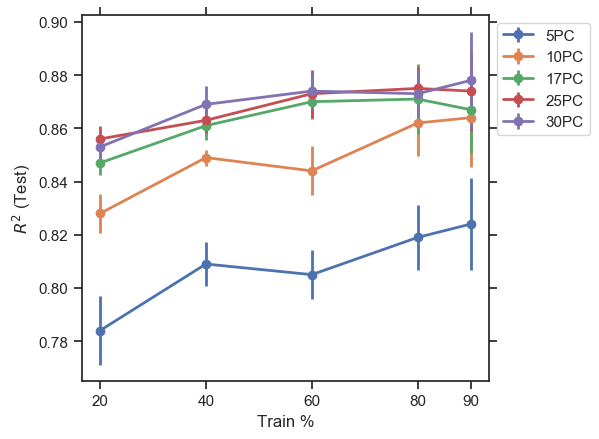

In [158]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_ts_10_4pc,yerr=y_r2_std_ts_10_4pc,label="5PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_8pc,yerr=y_r2_std_ts_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_16pc,yerr=y_r2_std_ts_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_32pc,yerr=y_r2_std_ts_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_46pc,yerr=y_r2_std_ts_10_46pc,fmt='-o',label="30PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Test)")
plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"r2_test_learning_curve_train_test_30feat_PCA.png",dpi=300)

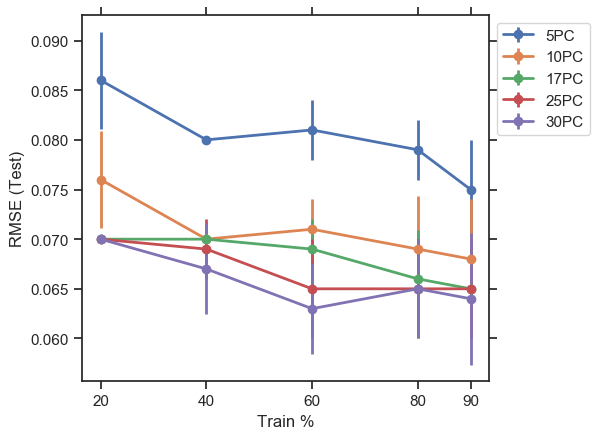

In [159]:
plt.tick_params(reset=True)
# plt.tick_params(axis='both',which='minor')
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_ts_10_4pc,yerr=y_rmse_std_ts_10_4pc,label="5PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_8pc,yerr=y_rmse_std_ts_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_16pc,yerr=y_rmse_std_ts_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_32pc,yerr=y_rmse_std_ts_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_46pc,yerr=y_rmse_std_ts_10_46pc,fmt='-o',label="30PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Test)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"rmse_test_learning_curve_train_test_30feat_PCA.png",dpi=300)

# Learning curve of PCs at a certain train-test% split

In [160]:
def plot_R2_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning_r2.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,0],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,0],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,0],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,0],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,0],yerr=std_train_score[:,0],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,0],yerr=std_test_score[:,0],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("R$^2$")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

train% = 0.80


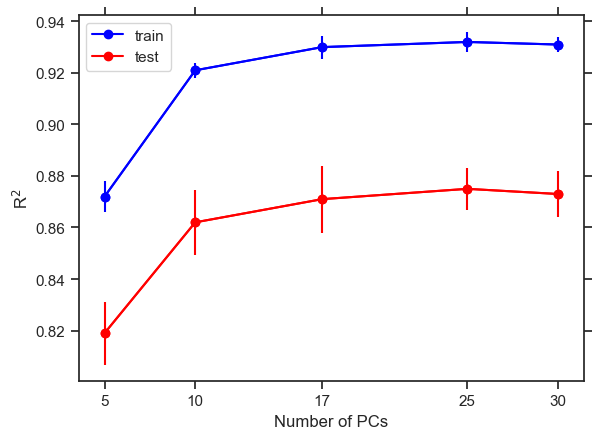

In [161]:
train_pc=-2
print(f"train% = {train_pcs[train_pc]:0.2f}")
plot_R2_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=folder_path+"R2_learning_curve_test_split_80pc_30featPCA_training.png")

In [162]:
def plot_RMSE_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,1],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,1],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,1],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,1],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,1],yerr=std_train_score[:,1],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,1],yerr=std_test_score[:,1],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

train% = 0.80


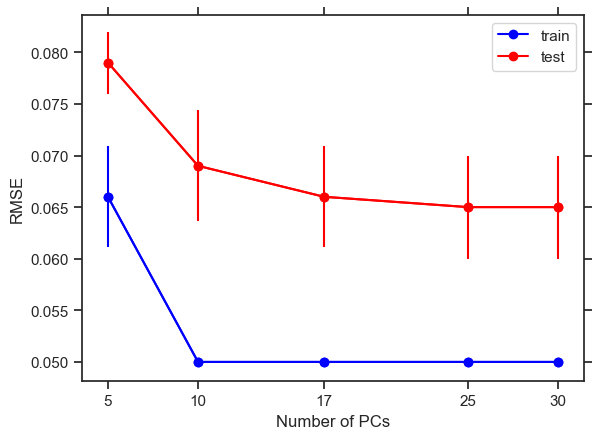

In [163]:
train_pc=-2
print(f"train% = {train_pcs[train_pc]:0.2f}")
plot_RMSE_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=folder_path+"RMSE_learning_curve_test_split_80pc_30featPCA_training.png")

# Final performance

In [164]:
# Use 16 PCs and 80-20% train-test split 
X=df_rdkit_uncorr_30  # df_xdata has 16 PCs
y=ERed_data.Ered_ag

y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=0.8,nPC=17,random_state=1)

returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


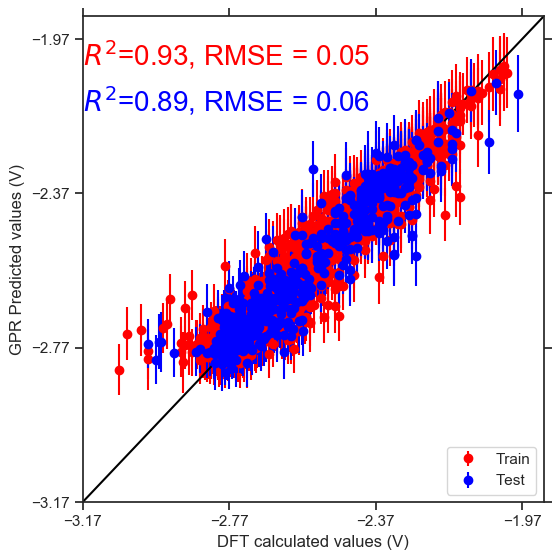

In [165]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename=folder_path+"base_model_17PCs_8020_2763mols.png")

returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


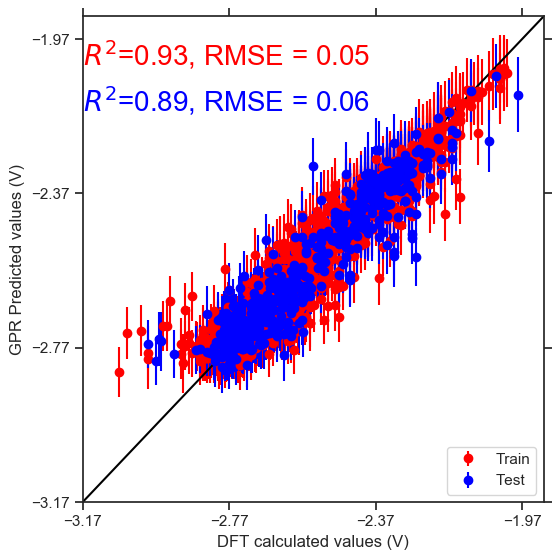

In [166]:
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=0.8,nPC=25,random_state=1)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename=folder_path+"base_model_25PCs_8020_2763mols.png")

returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


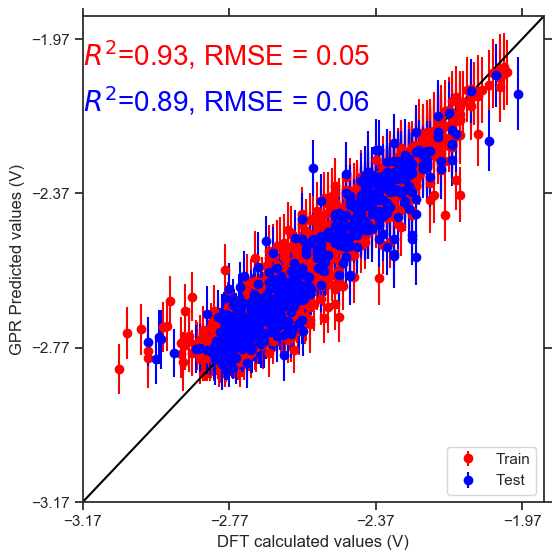

In [167]:
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=0.8,nPC=30,random_state=1)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename=folder_path+"base_model_30PCs_8020_2763mols.png")